In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


(-2.1270975024083203,
 2.0910232582665267,
 -2.1450180815215387,
 2.0346700751878997)

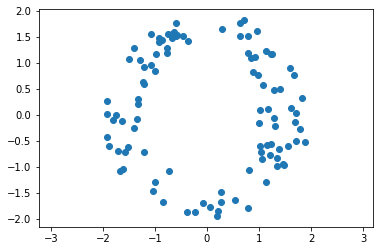

In [11]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
#def rand_annulus_pt():
#    r = uniform(0,1)
#    th = uniform(0,2*pi)
#    return (R+r*d) * cos(th), (R+r*d) * sin(th)
#annulus = np.array([(rand_annulus_pt()) for x in range(100)])

annulus = np.zeros((n, 2))
idx = 0
while (idx < n):
    x = uniform(-R-d, R+d)
    y = uniform(-R-d, R+d)
    if ((x*x + y*y) / ((R+d)*(R+d)) < 1) & (x*x/((R-d)*(R-d)) + y*y/(R*R) > 1):
        annulus[idx, :] = [x, y]
        idx = idx + 1

plt.scatter(*annulus.T)
plt.axis('equal')

In [12]:
prime = 23
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

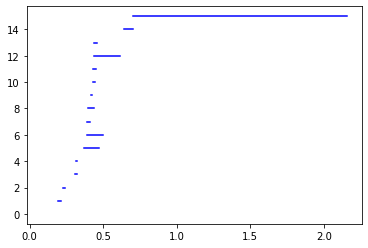

In [13]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [14]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.700073,2.15352)]

In [15]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.1270975024083203,
 2.0910232582665267,
 -2.1450180815215387,
 2.0346700751878997)

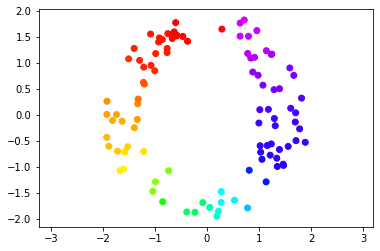

In [16]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

In [17]:
D = {}
data = {}
indexing = {}
ix = [0]*4
thr = 3
for s in vr:
    if s.dimension() == 0:
        continue
    elif s.data > thr:
        break
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[k.dimension()][k] = ix[k.dimension()]
            ix[k.dimension()] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[k.dimension()][k]) #cols
        data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [18]:
from scipy.optimize import minimize

In [19]:
l2_cocycle = [0]*len(coords[0]) #reorganize the coordinates so they fit with the coboundary indices
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)

bdry = CBd[0]

n, m = CBd[0].shape # edges X nodes

f = np.zeros((n,1)) # cocycle we need to smooth out, reorganize to fit coboundary
for c2 in cocycles[0]:
    if c2.element<(prime//2):
        f[indexing[1][vr[c2.index]]] = c2.element
    else:
        f[indexing[1][vr[c2.index]]] = c2.element-prime

In [20]:
# 2-norm

In [21]:
l = 1.
def cost(Z,L = l,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(B.shape[1],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

In [22]:

def grad(Z,L = l,F = f, B = bdry):
    if np.linalg.norm(B*Z.reshape(B.shape[1],1),ord=2) != 0:
        coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(B.shape[1],1),ord=2)
        print (coeff_A)
    else:
        coeff_A = 2
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * B.T * F).flatten()

In [23]:
res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)

2.046966996898472
2.067828799116994
2.0902082752362525
2.093410524857207
2.0935004223141185
2.093450761515286
2.0934504457219467
2.093451468682619
2.093451408528248


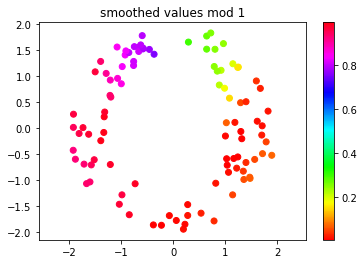

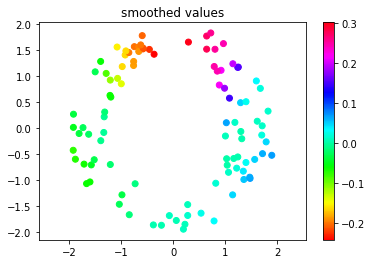

In [24]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')
plt.show()

Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')
plt.show()

In [25]:
# 1-norm

In [26]:
l = 1.
def grad(Z,L = l,F = f, B = bdry, toll = 1e-18):
    dz = B*Z.reshape(Z.shape[0],1)
    ndz = np.sign(np.where(dz<toll, 0, dz))
    #ndzf = np.sign(np.where(dz-f<toll, 0, dz-f))
    return np.array(B.T * (2 * (dz - f) + L * ndz)).flatten()

In [27]:
def cost(Z,L = l,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(Z.shape[0],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=1)

In [28]:
res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)

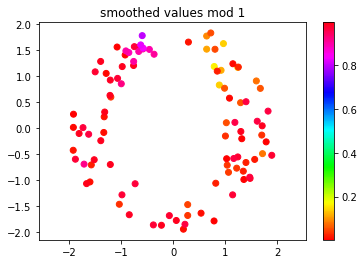

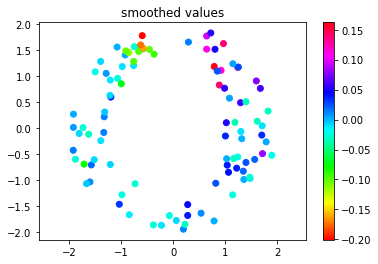

In [30]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')
plt.show()

Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')
plt.show()